In [1]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
from torch.fft import fft2, fftshift, ifft2, ifftshift
from tqdm import tqdm

from models.DAS import DAS
from models.PACT import TF_PACT, Wavefront_SoS
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import get_coordinates
from utils.simulations import *
from utils.utils_torch import crop_half, get_fourier_coord
from utils.visualization import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = '../data/'
results_path = '../results/'

### Load data

In [2]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation_easy.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)

SoS = load_mat(os.path.join(data_path, 'SoS_easy.mat'))

Successfully loaded data from "../data/IP.mat".
Successfully loaded data from "../data/sinogram_simulation_uniform.mat".
Successfully loaded data from "../data/sinogram_simulation_easy.mat".
Successfully loaded data from "../data/SoS_easy.mat".


### Preparations

In [3]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

Define parameters of the single-body SOS.

In [4]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].

Pick the small patch in the intil pressure image.

In [5]:
i, j = 18, 15
x, y, r, phi = get_coordinates(i, j, l)
x, y = (j-12)*l / 4, (12-i)*l / 4
k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
print(r*1e3, phi)

5.366563145999496 2.677945044588987


Define the delays for reconstruction and the elays for visualization, which is a subset of the former.

In [6]:
delays = np.arange(-8e-4, 8e-4, 5e-5)
ids_show = [12, 16, 20, 24, 28]
delays_show = delays[ids_show]
print(delays_show)

[-2.00000000e-04  3.25260652e-19  2.00000000e-04  4.00000000e-04
  6.00000000e-04]


### Conventional DAS

In [7]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero')
das.cuda()
das.eval()

DAS()

In [8]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram, device=device),
                  v0=torch.tensor(1513.0, device=device),
                  d_delay=torch.zeros(1, device=device),
                  ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [9]:
rec_das = rec_das[20*i:20*i+80, 20*j:20*j+80]

### Single Body

In [10]:
wavefront_sos = Wavefront_SoS(R, v0, x_vec, y_vec, n_points=180)
wavefront_sos.cuda()
wavefront_sos.eval()

tf_pact = TF_PACT(n_points=160, l=6.4e-3, n_delays=delays.shape[0])
tf_pact.cuda()
tf_pact.eval()

deconv = Wiener_Batched(lam=0e-3, order=1.2, device=device)
deconv.cuda()
deconv.eval()

Wiener_Batched()

In [11]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).cuda(), 
                    v0=torch.tensor(v0).cuda(),
                    d_delay=torch.tensor(d_delay).cuda(),
                    ring_error=torch.zeros(1).cuda())
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

DAS: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s]


In [12]:
gt = IP_img[20*i:20*i+80, 20*j:20*j+80]
thetas, wfs = wavefront_sos(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SoS).cuda())
tf_stack = tf_pact(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wfs)
obs_stack = img_stack[...,20*i:20*i+80, 20*j:20*j+80].unsqueeze(0)
rec_combined = deconv(obs_stack, tf_stack)
rec_combined = rec_combined.squeeze(0).squeeze(0).detach().cpu().numpy()

In [13]:
recs = []
deconv = Wiener_Batched(lam=0.005, order=3)
deconv.cuda()
deconv.eval()
for idx, delay in zip(ids_show, delays_show):
    tf = tf_stack[:,idx:idx+1,:,:]
    obs = obs_stack[:,idx:idx+1,:,:]
    rec = deconv(obs, tf)
    rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
    recs.append(rec)

In [14]:
recs = [standardize(img) for img in recs]
[rec_das, rec_combined, gt] = [standardize(img) for img in [rec_das, rec_combined, gt]]

In [15]:
rs = [0, R/4, r, 3*R/4, R]
psfs_show, tfs_show = [], []
for r in rs:
    x, y = r*np.cos(phi), r*np.sin(phi)
    thetas, wfs = wavefront_sos(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SoS).cuda())
    tf = tf_pact(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wfs).squeeze(0).detach().cpu()
    tf = tf[ids_show,...]
    psf = crop_half(fftshift((ifft2(tf)), dim=(-2,-1)).real)
    psf /= psf.sum(dim=(-2,-1)).unsqueeze(-1).unsqueeze(-1)
    psfs_show.append(psf)
    tfs_show.append(tf)
psfs_show, tfs_show = torch.stack(psfs_show, dim=0), torch.stack(tfs_show, dim=0)
psfs_show.shape

torch.Size([5, 5, 80, 80])

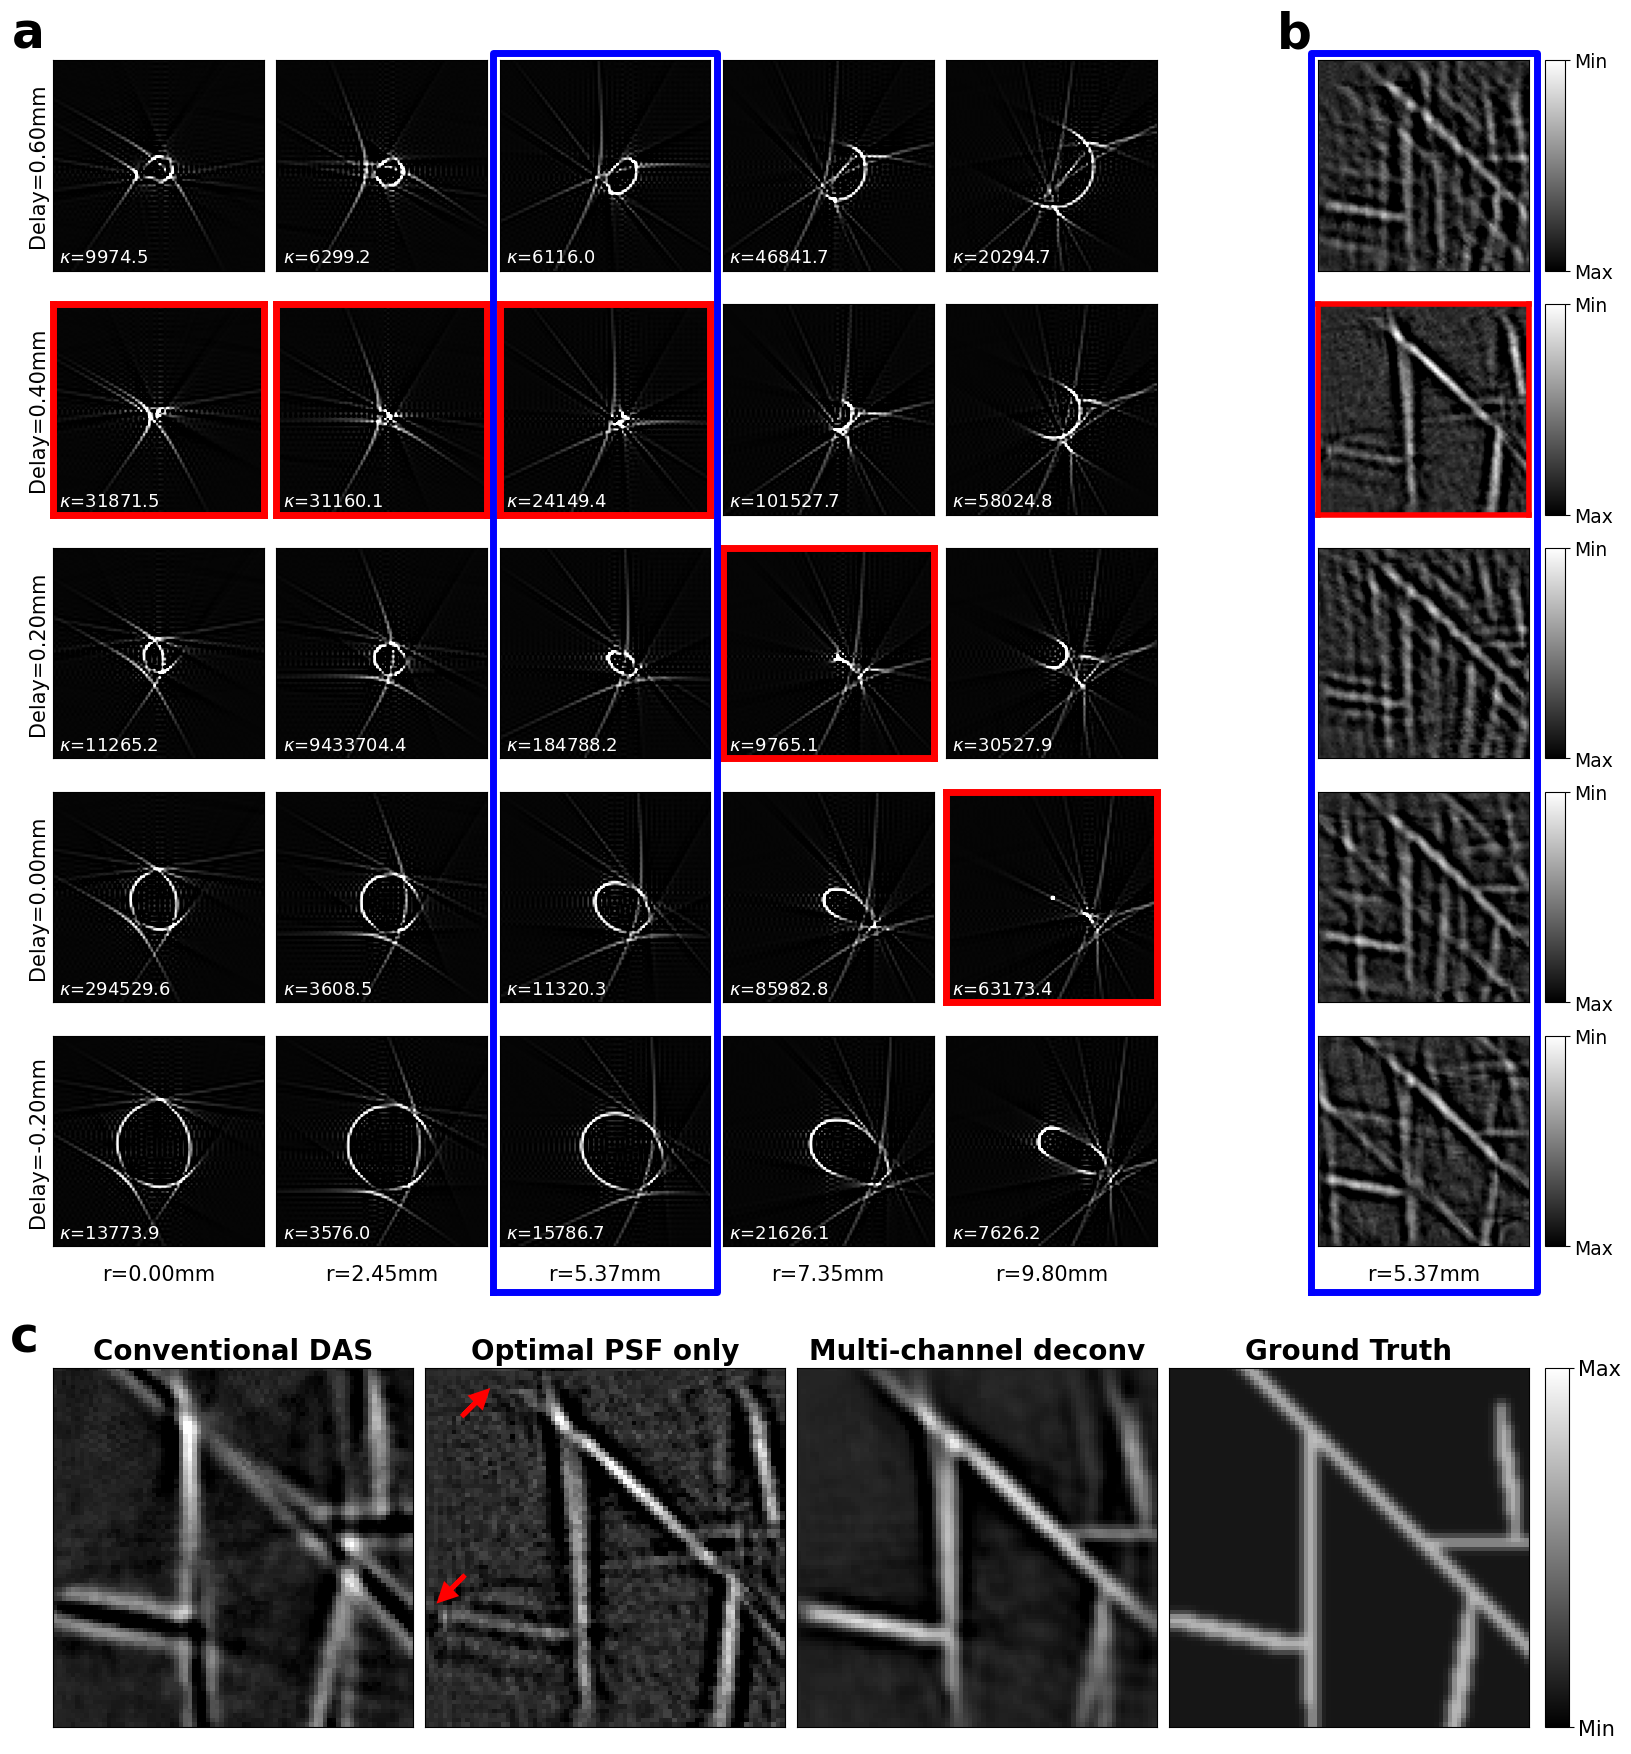

In [16]:
best_ids = [3,3,3,2,1]

fig, main_ax = plt.subplots(figsize=(20, 22))
gs = GridSpec(21, 21)
norm_img = Normalize(vmax=5, vmin=-1)
norm_psf = Normalize(vmin=-1e-3, vmax=0.05)
for i, r_i in enumerate(rs):
    for j, delay in enumerate(delays_show):
        ax = plt.subplot(gs[12-3*j:15-3*j,3*i:3*(i+1)])
        plt.imshow(psfs_show[i,j], cmap='gray', norm=norm_psf)
        # plt.imshow(psfs_show[i,j].abs())
        plt.xticks([])
        plt.yticks([])
        plt.title('$\kappa$={:.1f}'.format(condition_number(tfs_show[i,j])), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        if i == 0:
            plt.ylabel('Delay={:.2f}mm'.format(delays_show[j]*1e3), fontsize=15)
            if j == 4:
                plt.title('a', loc='center', x=-0.12, y=1.02, fontsize=35, fontweight='bold', color='black')
        # elif i == 4:
        #     cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
        #     cb = plt.colorbar(cax=cax)
            # cb.set_ticks([3e-4, 0.04])
            # cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)
        if j == 0:
            ax.set_title('r={:.2f}mm'.format(r_i*1e3), fontsize=15, y=-0.2)
        elif j == best_ids[i]:
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_color('red')
                ax.spines[loc].set_linewidth(5)

                
for j, delay in enumerate(delays_show):
    ax = plt.subplot(gs[3*(4-j):3*(5-j),17:20])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recs[j], cmap='gray', norm=norm_img)
    if j == 0:
        ax.set_title('r={:.2f}mm'.format(rs[2]*1e3), fontsize=15, y=-0.2)
    elif j == 4:
        plt.title('b', loc='center', x=-0.11, y=1.02, fontsize=35, fontweight='bold', color='black')
    elif j == best_ids[2]:
        for loc in ['bottom', 'top', 'left', 'right']:
            ax.spines[loc].set_color('red')
            ax.spines[loc].set_linewidth(4)
         
    cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
    cb = plt.colorbar(cax=cax, norm=norm_img)
    cb.set_ticks([5, -1])
    cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)

for j, (img, title) in enumerate(zip([rec_das, recs[best_ids[2]], rec_combined, gt], ['Conventional DAS', 'Optimal PSF only', 'Multi-channel deconv', 'Ground Truth'])):
    ax = plt.subplot(gs[16:21,5*j:5*(j+1)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray', norm=norm_img)
    plt.title(title, fontsize=20, fontweight='bold')
    if j == 0:
        plt.title('c', loc='left', x=-0.12, y=1.02, fontsize=35, fontweight='bold', color='black')
    elif j == 1:
        plt.arrow(8, 10, 3, -3, color='red', linewidth=3.5, head_width=3, head_length=3)
        plt.arrow(8, 46, -3, 3, color='red', linewidth=3.5, head_width=3, head_length=3)
    elif j == 3:
        cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([-1, 5])
        cb.set_ticklabels(['Min', 'Max'], fontsize=15)

main_ax.set_zorder(20)
main_ax.axis('off')
main_ax.set_xlim(0, 21)
main_ax.set_ylim(0, 21)
y1, y2 = 5.6, 20.96
x1, x2 = 5.96, 8.99
x3, x4 = 17.04, 20.1
main_ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='blue', linewidth=5)
main_ax.plot([x3, x3, x4, x4, x3], [y1, y2, y2, y1, y1], color='blue', linewidth=5)

plt.savefig('figure_refocusing.png', dpi=256, bbox_inches='tight')